In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 路径声明

In [2]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.hdf5'

# 设定分类数

In [3]:
# 如果用原本的数据 就用origin csv 分类数设为4 否则 自己按照对应的情况改

In [4]:
NUM_CLASSES = 5

# 输入数据格式 长度为16 二维数组

In [5]:
TIME_STEPS = 16
DIMENSION = 2

# 读取训练集数据

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 模型构建

In [9]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                792       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 1,097
Trainable params: 1,097
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 模型检查点回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 用于提前结束的回调
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# 模型编译
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 模型训练

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

ch 347/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.5568 - accuracy: 0.8065 - val_loss: 0.3092 - val_accuracy: 0.9338

Epoch 00347: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 348/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.5625 - accuracy: 0.8030 - val_loss: 0.3079 - val_accuracy: 0.9351

Epoch 00348: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 349/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.5778 - accuracy: 0.7934 - val_loss: 0.3070 - val_accuracy: 0.9351

Epoch 00349: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 350/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.5614 - accuracy: 0.8127 - val_loss: 0.3053 - val_accuracy: 0.9351

Epoch 00350: saving model to model/point_history_classifier\point_history_classifier.hdf5
Epoch 351/1000
36/36 [==============================] - 0s 3ms/

In [14]:
# 加载保存的模型
model = tf.keras.models.load_model(model_save_path)

In [15]:
# 预测测试
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.6818524e-37 9.0651619e-01 6.1690961e-03 8.4728308e-02 2.5864600e-03]
1


# 混淆矩阵

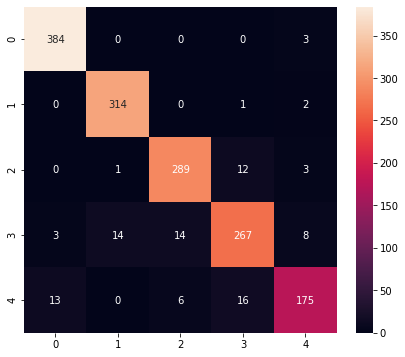

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       387
           1       0.95      0.99      0.97       317
           2       0.94      0.95      0.94       305
           3       0.90      0.87      0.89       306
           4       0.92      0.83      0.87       210

    accuracy                           0.94      1525
   macro avg       0.93      0.93      0.93      1525
weighted avg       0.94      0.94      0.94      1525



In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# 转换为Tensorflow-Lite模型

In [17]:
# 保存为仅用于推理的模型
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [18]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [19]:
# 转换模型（量化）
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Van5SE\AppData\Local\Temp\tmp450pctng\assets


6288

# 推理测试

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [21]:
# 获取 输入输出 张量
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'input_1', 'index': 0, 'shape': array([ 1, 32]), 'shape_signature': array([-1, 32]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# 推理执行
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.6818521e-37 9.0651602e-01 6.1691101e-03 8.4728450e-02 2.5864670e-03]
1
